Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


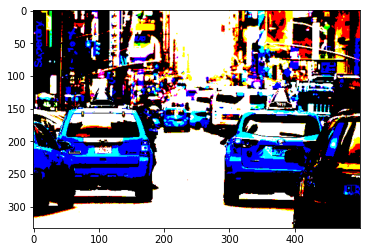

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


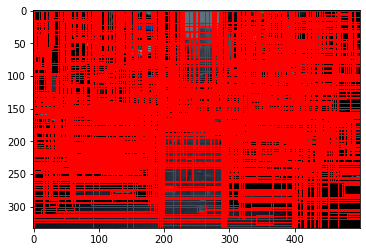

In [29]:
import sys

sys.path.append("..")

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import PIL
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from model.model_imagenet.MOBILE_NET_V2 import Pretrain_mobilenet_v2
from model.model_imagenet.imagenet_labels import Imagenet_labels
import cv2

import os

os.environ["imagenet_dataset"] = "/home/howard/project/object-detection/data/imagenet"

md = Pretrain_mobilenet_v2()


def bbox_xyxy(bboxes):
    res = np.copy(bboxes)
    res[:, 2] = bboxes[:, 0] + bboxes[:, 2]
    res[:, 3] = bboxes[:, 1] + bboxes[:, 3]
    return res


def bbox_xywh(bboxes):
    res = np.copy(bboxes)
    res[:, 2] = bboxes[:, 2] - bboxes[:, 0]
    res[:, 3] = bboxes[:, 3] - bboxes[:, 1]
    return res


img_dir = "/home/howard/project/object-detection/images/test/traffic_2.jpeg"
img_tensor = tf.image.resize(
    tf.cast(
        tf.convert_to_tensor(np.asarray(PIL.Image.open(img_dir))),
        tf.dtypes.float32,
    ),
    [500, 500],
    method="bilinear",
    preserve_aspect_ratio=True,
).numpy()

preprocess = keras.applications.vgg16.preprocess_input(img_tensor)

plt.imshow(preprocess)
plt.show()
plt.close()

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

ss.setBaseImage(preprocess)
ss.switchToSelectiveSearchFast()  # reduce number of boxes

boxes = ss.process()

fig, ax = plt.subplots(1)

plt.imshow(img_tensor / 255.0)
for i, rect in enumerate(boxes):
    r = mpatches.Rectangle(
        (rect[0], rect[1]),
        rect[2],
        rect[3],
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )
    ax.add_patch(r)

plt.show()
plt.close()

lb = Imagenet_labels()
predictions = md.predict(np.copy(img_tensor), boxes)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


===== FILTER LABEL WITH CAR =====
[['n02966687' "carpenter's kit, tool kit"]
 ['n04285008' 'sports car, sport car']
 ['n02966687' "carpenter's kit, tool kit"]
 ['n03895866' 'passenger car, coach, carriage']
 ['n02965783' 'car mirror']
 ['n02965783' 'car mirror']
 ['n03895866' 'passenger car, coach, carriage']
 ['n03895866' 'passenger car, coach, carriage']
 ['n03895866' 'passenger car, coach, carriage']
 ['n03895866' 'passenger car, coach, carriage']
 ['n02965783' 'car mirror']
 ['n02965783' 'car mirror']
 ['n03895866' 'passenger car, coach, carriage']
 ['n02965783' 'car mirror']
 ['n02965783' 'car mirror']
 ['n02966687' "carpenter's kit, tool kit"]
 ['n03895866' 'passenger car, coach, carriage']
 ['n02966687' "carpenter's kit, tool kit"]
 ['n03895866' 'passenger car, coach, carriage']
 ['n02966687' "carpenter's kit, tool kit"]
 ['n02966687' "carpenter's kit, tool kit"]
 ['n03895866' 'passenger car, coach, carriage']
 ['n02965783' 'car mirror']
 ['n03895866' 'passenger car, coach, carr

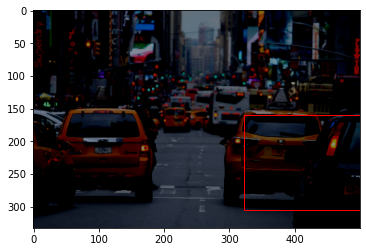

In [32]:
# Filter bbox with label contain "car"
boxes_label = lb.labels[predictions[:, 0].astype(np.int32)]
label_filter_idx = np.where(
    (np.char.find(boxes_label[:, 1], "car") != -1)
    | (np.char.find(boxes_label[:, 1], "vehicle") != -1),
    True,
    False,
)

print("===== FILTER LABEL WITH CAR =====")
print(boxes_label[label_filter_idx])
print(label_filter_idx)
print("=====")

car_bboxes = boxes[label_filter_idx]
car_predictions = predictions[label_filter_idx, 1]
nms = tf.image.non_max_suppression(
    bbox_xyxy(car_bboxes),
    car_predictions,
    max_output_size=20,
    iou_threshold=0.5,
    score_threshold=0.5,
)

filter_bboxes = car_bboxes[nms.numpy()]

fig, ax = plt.subplots(1)

plt.imshow(img_tensor / 255.0)
for i, rect in enumerate(filter_bboxes):
    r = mpatches.Rectangle(
        (rect[0], rect[1]),
        rect[2],
        rect[3],
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )
    ax.add_patch(r)

plt.show()
plt.close()